In [ ]:
# !pip install plotly
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import pickle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
%matplotlib inline
plt.style.use('ggplot') # 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일을 사용

In [ ]:
with open('./bc/high_low_dict.pickle', 'rb') as f:
    data = pickle.load(f)

In [ ]:
# preprocessing & grid search 를 통한 최적 파라미터 추출
def random_forest_feature_importance(p_group):
  df = data[p_group]
  scaler = StandardScaler()
  df['exp_min'] = scaler.fit_transform(df['exp_min'].values.reshape(-1,1))
  df['unit_price'] = scaler.fit_transform(df['unit_price'].values.reshape(-1,1))
  #*X
  #* categorical  -> 'DAY_NUM','season', 'timeslot', 'holiday', <<'exp_min','unit_price'>>
  #* numeric -> 'mask_ratio', 'parcel_ratio',
  #*Y
  #* 'score'
  #X,Y 변수 선언
  X = df[['exp_min','unit_price', 'DAY_NUM', 'season', 'timeslot','holiday']]
  Y = df['score'].astype('category')
  #X category로 바꿔서 원 핫 인코딩
  X['DAY_NUM']= X['DAY_NUM'].astype('category')
  X['season']= X['season'].astype('category')
  X['timeslot'] = X['timeslot'].astype('category')
  X = pd.get_dummies(X)
  x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)
  from sklearn.model_selection import GridSearchCV
  # 최적의 parameter를 찾기위해
  params = { 'n_estimators' : [10, 100],
            'max_depth' : [3,5,7,9,11],
            'min_samples_leaf' : [4, 8, 12, 18],
            'min_samples_split' : [4, 8, 16, 20]
              }
  # RandomForestClassifier 객체 생성 후 GridSearchCV 수행
  rf_clf = RandomForestClassifier(random_state = 0, n_jobs = -1)
  grid_cv = GridSearchCV(rf_clf, param_grid = params, cv = 3, n_jobs = -1)
  grid_cv.fit(x_train, y_train)
  print('최적 하이퍼 파라미터: ', grid_cv.best_params_)
  print('최고 예측 정확도: {:.4f}'.format(grid_cv.best_score_))

  # 학습 진행
  rf = RandomForestClassifier(n_estimators = grid_cv.best_params_['n_estimators'],
                              max_depth = grid_cv.best_params_['max_depth'],
                              min_samples_leaf = grid_cv.best_params_['min_samples_leaf'],
                              min_samples_split = grid_cv.best_params_['min_samples_split'],
                              random_state = 0,
                              n_jobs = -1)
  rf.fit(x_train, y_train)

  # 예측
  y_pred = rf.predict(x_test)
  print(y_pred)
  print(list(y_test))

  # 정확도 확인
  print('정확도 :', metrics.accuracy_score(y_test, y_pred))
  #random Forest의 각 피처의 중요도 시각화 : featureimportances
  import matplotlib.pyplot as plt
  import seaborn as sns
  %matplotlib inline

  # 주요한 feature 그래프로 확인
  ftr_importances_values = rf.feature_importances_
  ftr_importances = pd.Series(ftr_importances_values, index = x_train.columns)
  ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

  plt.figure(figsize=(8,6))
  plt.title(p_group)

  sns.barplot(x=ftr_top20, y=ftr_top20.index)

  plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

최적 하이퍼 파라미터:  {'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 100}
최고 예측 정확도: 0.7083
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0]
정확도 : 0.8571428571428571


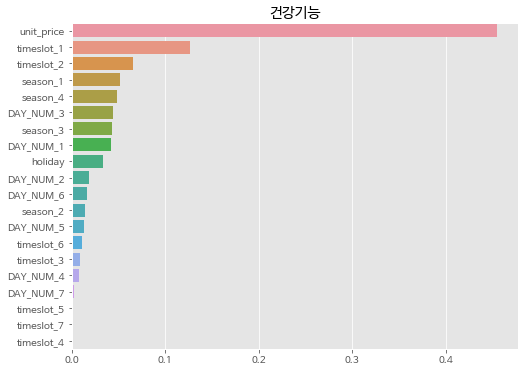

In [ ]:
random_forest_feature_importance('건강기능')